<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/09_AEPFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 122kB 20.5MB/s 
     |████████████████████████████████| 2.2MB 20.1MB/s 


In [ ]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [ ]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [ ]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [ ]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [ ]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath="/content/drive/MyDrive/colab-data/total434.pfs.se.norm.coxph.feather"

In [ ]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [ ]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [ ]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [ ]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [ ]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=41, bias=True)
  )
  (survnet): Sequenti

In [ ]:
from torchsummary import summary
summary(model=netaesurv, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]          86,016
              ReLU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              ReLU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 64]           8,256
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

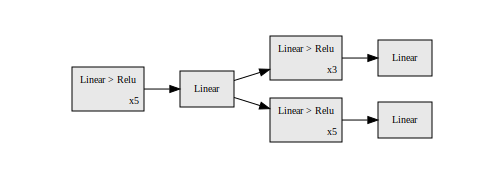

In [ ]:
import hiddenlayer as hl
hl.build_graph(netaesurv, torch.zeros([1, in_features]))

In [ ]:
# loss
loss = LossAELogHaz(0.6)

In [ ]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [ ]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [ ]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

0:	[5s / 5s],		train_loss: 15.6712,	train_loss_surv: 1.2815,	train_loss_ae: 37.2556,	val_loss: 1.3504,	val_loss_surv: 1.4425,	val_loss_ae: 1.2122
1:	[5s / 10s],		train_loss: 1.1026,	train_loss_surv: 1.1702,	train_loss_ae: 1.0012,	val_loss: 1.2969,	val_loss_surv: 1.3557,	val_loss_ae: 1.2088
2:	[4s / 15s],		train_loss: 1.4798,	train_loss_surv: 1.6035,	train_loss_ae: 1.2942,	val_loss: 1.2971,	val_loss_surv: 1.3627,	val_loss_ae: 1.1987
3:	[5s / 20s],		train_loss: 1.0195,	train_loss_surv: 1.0172,	train_loss_ae: 1.0231,	val_loss: 1.2715,	val_loss_surv: 1.3303,	val_loss_ae: 1.1833
4:	[5s / 25s],		train_loss: 0.9832,	train_loss_surv: 0.9938,	train_loss_ae: 0.9673,	val_loss: 1.2863,	val_loss_surv: 1.3540,	val_loss_ae: 1.1847
5:	[5s / 31s],		train_loss: 0.9455,	train_loss_surv: 0.9370,	train_loss_ae: 0.9581,	val_loss: 1.3218,	val_loss_surv: 1.4087,	val_loss_ae: 1.1914
6:	[5s / 36s],		train_loss: 0.9893,	train_loss_surv: 0.9546,	train_loss_ae: 1.0413,	val_loss: 1.3861,	val_loss_surv: 1.5250,	val_

In [ ]:
res = model.log.to_pandas()

In [ ]:
res.tail(20)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
80,0.784632,0.685591,0.933195,1.693188,2.029793,1.188280
81,0.786339,0.688178,0.933581,2.240824,2.942878,1.187743
82,0.816228,0.741199,0.928770,1.536312,1.770220,1.185451
83,0.815712,0.738450,0.931606,1.592194,1.864546,1.183666
84,0.820192,0.746690,0.930445,1.541157,1.779745,1.183275
85,0.813926,0.735526,0.931526,1.574099,1.834756,1.183113
86,0.816225,0.737971,0.933606,1.566802,1.820986,1.185526
87,0.840452,0.778552,0.933301,1.840937,2.274508,1.190580
88,0.923987,0.911098,0.943321,1.761244,2.137611,1.196693
89,0.862469,0.807089,0.945538,1.423471,1.575873,1.194868


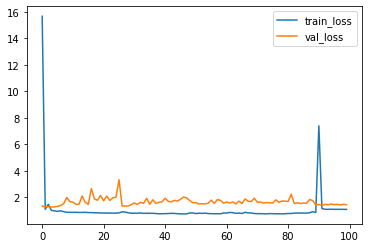

In [ ]:
_ = res[['train_loss', 'val_loss']].plot()

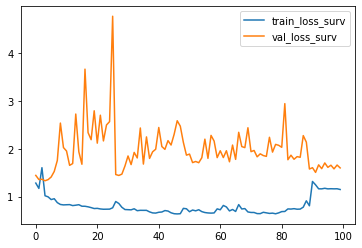

In [ ]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

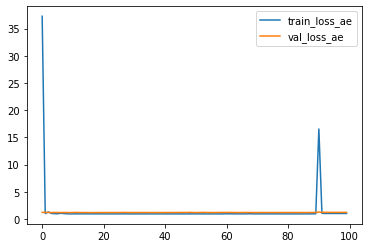

In [ ]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [ ]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [ ]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.999971,0.999971,0.999971,0.999971,0.999971
1.455556,0.969731,0.969731,0.969731,0.969731,0.969731
2.911111,0.939491,0.939491,0.939491,0.939491,0.939491
4.366667,0.909252,0.909252,0.909252,0.909252,0.909252
5.822222,0.879012,0.879012,0.879012,0.879012,0.879012
...,...,...,...,...,...
125.177778,0.008178,0.008178,0.008178,0.008178,0.008178
126.633333,0.006146,0.006146,0.006146,0.006146,0.006146
128.088889,0.004114,0.004114,0.004114,0.004114,0.004114
129.544444,0.002082,0.002082,0.002082,0.002082,0.002082


In [ ]:
surv2.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
0.000000,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971
1.455556,0.969731,0.969731,0.969731,0.969731,0.969731,0.969731,0.969731,0.969731,0.969731,0.969731
2.911111,0.939491,0.939491,0.939491,0.939491,0.939491,0.939491,0.939491,0.939491,0.939491,0.939491
4.366667,0.909252,0.909252,0.909252,0.909252,0.909252,0.909252,0.909252,0.909252,0.909252,0.909252
5.822222,0.879012,0.879012,0.879012,0.879012,0.879012,0.879012,0.879012,0.879012,0.879012,0.879012
...,...,...,...,...,...,...,...,...,...,...
125.177778,0.008178,0.008178,0.008178,0.008178,0.008178,0.008178,0.008178,0.008178,0.008178,0.008178
126.633333,0.006146,0.006146,0.006146,0.006146,0.006146,0.006146,0.006146,0.006146,0.006146,0.006146
128.088889,0.004114,0.004114,0.004114,0.004114,0.004114,0.004114,0.004114,0.004114,0.004114,0.004114
129.544444,0.002082,0.002082,0.002082,0.002082,0.002082,0.002082,0.002082,0.002082,0.002082,0.002082


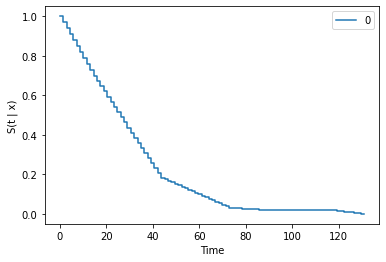

In [ ]:
surv1.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

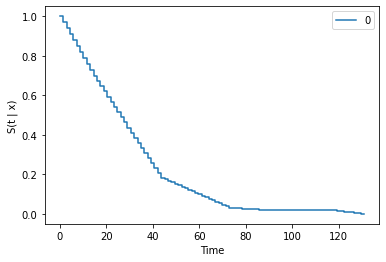

In [ ]:
surv2.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
model.predict(x_test1[:2])

array([[-10.427992  ,  -0.83587277,  -0.51593745,   0.3160803 ,
         -0.35261053,   0.8643018 ,  -0.5676364 ,  -6.173911  ,
         -5.9846725 ,   6.006667  ],
       [-10.427992  ,  -0.83587277,  -0.51593745,   0.3160803 ,
         -0.35261053,   0.8643018 ,  -0.5676364 ,  -6.173911  ,
         -5.9846725 ,   6.006667  ]], dtype=float32)

In [ ]:
model.predict_net(x_test1[:1])

(array([[-10.427991  ,  -0.83587277,  -0.51593745,   0.31608033,
          -0.35261047,   0.8643018 ,  -0.5676364 ,  -6.173911  ,
          -5.9846725 ,   6.006667  ]], dtype=float32),
 array([[ 0.0367692 , -0.01741931, -0.00726779,  0.01332553,  0.00598496,
          0.07035309, -0.02499136,  0.03521502,  0.02661629,  0.0040535 ,
         -0.00961292, -0.00908348,  0.03685755,  0.00149958, -0.00962301,
          0.03415236, -0.000754  , -0.00828171, -0.01337377,  0.0215282 ,
         -0.04127207,  0.01196919,  0.01714903, -0.03749722,  0.02246907,
          0.02909294,  0.01847257, -0.00534394, -0.0053225 , -0.00998791,
          0.02564961, -0.0068378 ,  0.02815288, -0.00362345, -0.01115112,
          0.03419432, -0.03566173,  0.02479804,  0.01298883,  0.02613592,
         -0.01261495]], dtype=float32))

In [ ]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [ ]:
evs1.concordance_td()

0.522680412371134

In [ ]:
evs2.concordance_td()

0.5218427323272439

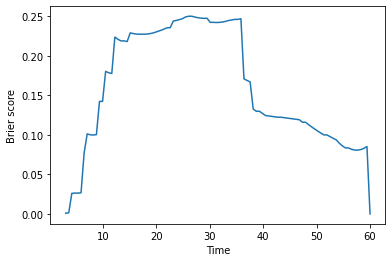

In [ ]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

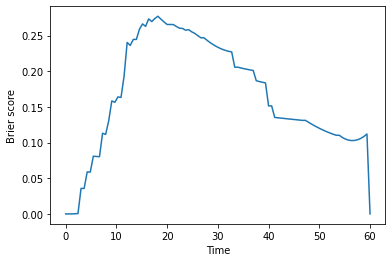

In [ ]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

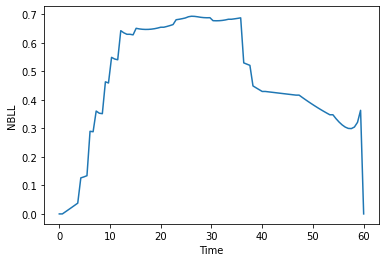

In [ ]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

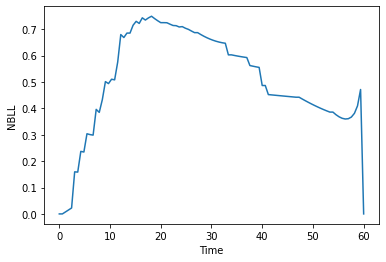

In [ ]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
evs1.integrated_brier_score(time_grid)

0.15382101901917705

In [ ]:
evs1.integrated_nbll(time_grid)

0.47299722912958947

In [ ]:
evs2.integrated_brier_score(time_grid)

0.16821802538472871

In [ ]:
evs2.integrated_nbll(time_grid)

0.5081176736697425